# Derivation

Discretely many importance weights and rewards, control variates $\vec{\tau}$, maximum likelihood of sample $\{ (w_n, r_n, \vec{\tau}_n) \}_{n=1}^N$ from $h$ is 
\begin{alignat}{2}
&\!\max_{Q \succeq 0} &\qquad& \sum_n \log(Q_{w_n, r_n, \vec{\tau}_n}),\label{eq:mle} \\
&\text{subject to} &  & \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} = 1, \tag{$\beta$} \label{eq:mlesumw} \\
&                  &  & \sum_{w,r,\vec{\tau}} w Q_{w,r,\vec{\tau}} = 1, \tag{$\gamma$} \label{eq:mlesum} \\
&                  &  & \sum_{w,r,\vec{\tau}} \vec{\tau} Q_{w,r,\vec{\tau}} = 0, \tag{$\vec{\delta}$} \label{eq:mlesumdr}
\end{alignat}
Estimate is $\hat V(\pi) = \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} w r$.

Dual (ignoring constants) is $$
\ldots
$$

# Tests

## Comparison with CVX

In [1]:
# CVXPY (primal) implementation

class MLETest:
    @staticmethod
    def cvxdualestimate(data, cvpoly, rmin=0, rmax=1):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
            ncvs = len(cvsi)
        assert n >= 1
        cdict.default_factory = None
        
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])

        beta = cp.Variable()
        delta = cp.Variable(ncvs)
        
        constraints = [ 
            1 + beta * (w - 1) + cp.matmul(np.array(cv), delta) >= 0
            for (w, cv) in cvpoly
        ]
    
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(1 + beta * (wvec - 1) + cp.matmul(cvsmat, delta))))), 
                          constraints)
        prob.solve(solver='ECOS')
        
        Q = np.array([ c / (n * (1 + beta.value * (w - 1) + delta.value.dot(np.array(cvs))))
                       for (w, r, cvs), c in cdict.items() ])
        rawsumofw = wvec.dot(Q)
        rawsumofone = np.sum(Q)
        rawsumofcvs = np.matmul(cvsmat.T, Q)
        
        vhat = 0
        for (w, r, cvs), c in cdict.items():
            q = c / (n * (1 + beta.value * (w - 1) + delta.value.dot(np.array(cvs))))
            vhat += q * w * r
           
        # NB: no explicit primal reconstruction necessary (!)
        vmin = vhat + max(0.0, 1 - rawsumofw) * rmin
        vmax = vhat + max(0.0, 1 - rawsumofw) * rmax
        vhat += max(0.0, 1 - rawsumofw) * (rmax - rmin) / 2
        
        from scipy.special import xlogy

        return vhat, {
            'vmin': vmin,
            'vmax': vmax,
            'beta': n * beta.value,
            'delta': n * delta.value,
            'qstar': { (w, r, cvs): c / (n * (1 + beta.value * (w - 1) + delta.value.dot(np.array(cvs))))
                       for (w, r, cvs), c in cdict.items() if c > 0  },
            'likelihood': np.sum(xlogy(C, Q)),
            'rawsumofone': rawsumofone,
            'rawsumofw': rawsumofw,
            'rawsumofcvs': rawsumofcvs,
        }
        
    @staticmethod
    def cvxestimate(data, cvpoly, rmin=0, rmax=1):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
        assert n >= 1
        for (w, cv) in cvpoly:
            for r in (rmin, rmax):
                cdict[(w, r, tuple(cv))] += 0
        cdict.default_factory = None
                       
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])
        Q = cp.Variable(len(C))
                       
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(Q)))), [
            cp.sum(cp.multiply(wvec, Q)) == 1,
            cp.sum(Q) == 1,
            cp.matmul(cvsmat.T, Q) == 0
        ])
        prob.solve(solver='ECOS')
        vmax, vmin = 0, 0
        for ((w, r, _), c), q in zip(cdict.items(), Q.value):
            if c > 0:
                vmax += q * w * r
                vmin += q * w * r
            else:
                vmax += q * w * rmax
                vmin += q * w * rmin
                                          
        vhat = (vmin + vmax) / 2              
 
        from scipy.special import xlogy
    
        return vhat, { 
            'vmax': vmax,
            'vmin': vmin,
            'qstar': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c > 0 },
            'likelihood': np.sum(xlogy(C, Q.value)),
            'sumofone': np.sum(Q.value),
            'sumofw': wvec.dot(Q.value),
            'sumofcvs': np.matmul(cvsmat.T, Q.value)
        }
    
def flass():
    from importlib import reload
    import numpy as np
    import MLE.MLE
    import environments.DoubleDouble
    reload(MLE.MLE)
    
    numactions = 5
    ddm = environments.DoubleDouble.DoubleDouble(numactions=numactions, seed=48, wsupport=[0, 2, 1000], expwsq=100)
    (truevalue, data) = ddm.samplewithcvs(12000)
    import numpy
    return (truevalue, data, 
            MLETest.cvxestimate(data, cvpoly=ddm.range()),
            MLETest.cvxdualestimate(data, cvpoly=ddm.range()),
            MLE.MLE.estimate(lambda: ((c, w, r) for c, w, r, _ in data), wmin=ddm.range('wmin'), wmax=ddm.range('wmax')),
            MLE.MLE.estimatewithcv(lambda: data, rangefn=ddm.range, raiseonerr=True),
           ) 

def turg():
    from pprint import pformat
    from numpy import array
    import MLE.MLE
    
    for data in [
    ]:
        print(pformat(
            MLETest.cvxestimate(data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                    cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)
        print(pformat(
            MLETest.cvxdualestimate(data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                    cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)
        print(pformat(
            MLE.MLE.estimatewithcv(datagen=lambda: data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                   cvmin=data['cvmin'], cvmax=data['cvmax'])            
        ), flush=True)

turg()
flass()

(0.019239877299983728,
 [(1370, 0, 0, array([ 0.,  0., -1.,  0.,  0.])),
  (1278, 0, 0, array([-1.,  0.,  0.,  0.,  0.])),
  (1332, 0, 0, array([ 0.,  0.,  0.,  0., -1.])),
  (1319, 0, 0, array([ 0., -1.,  0.,  0.,  0.])),
  (1335, 0, 0, array([ 0.,  0.,  0., -1.,  0.])),
  (1087, 2, 0, array([0., 1., 0., 0., 0.])),
  (997, 2, 0, array([0., 0., 0., 0., 1.])),
  (1080, 2, 0, array([1., 0., 0., 0., 0.])),
  (1082, 2, 0, array([0., 0., 1., 0., 0.])),
  (1091, 2, 0, array([0., 0., 0., 1., 0.])),
  (5, 2, 1, array([0., 0., 1., 0., 0.])),
  (5, 2, 1, array([0., 1., 0., 0., 0.])),
  (8, 2, 1, array([0., 0., 0., 0., 1.])),
  (7, 2, 1, array([1., 0., 0., 0., 0.])),
  (3, 2, 1, array([0., 0., 0., 1., 0.])),
  (1, 1000, 0, array([999.,   0.,   0.,   0.,   0.]))],
 (0.049225549880349564,
  {'vmax': 0.09378555852823296,
   'vmin': 0.004665541232466164,
   'qstar': {(0, 0, (0.0, 0.0, -1.0, 0.0, 0.0)): 0.11405251089714717,
    (0, 0, (-1.0, 0.0, 0.0, 0.0, 0.0)): 0.10692634784852137,
    (0, 0, (0.0, 

In [7]:
def testestimate():
    from importlib import reload
    from math import ceil
    from pprint import pformat
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys
    import environments.DoubleDouble

    reload(MLE.MLE)

    wsupport = [ 0, 2, 10 ]
    wmax = wsupport[-1]
    env = environments.DoubleDouble.DoubleDouble(numactions=3, seed=45, wsupport=wsupport, expwsq=5)
    
    for ndata in tqdm(map(ceil, np.logspace(1, 6, 14)), file=sys.stderr, total=14):
        for i in range(101):
            (truevalue, data) = env.samplewithcvs(ndata)
            vhat, qstar = MLE.MLE.estimatewithcv(lambda: data, rangefn=env.range, raiseonerr=True)            
            cvxvhat, cvxqstar = MLETest.cvxdualestimate(data, cvpoly=env.range())
 
            assert np.allclose(vhat, cvxvhat, atol=1e-4), pformat(
            {
                'truevalue': truevalue,
                'data': [(c, w, r, cvs) for c, w, r, cvs in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                            
testestimate()

100%|██████████| 14/14 [00:49<00:00,  8.39s/it]


# Comparison with baselines

In [9]:
def produceresults(env, method, minexp=1, maxexp=5, numpts=20, ndataperpt=10000):
    from math import ceil
    import numpy as np
    
    for ndata in map(ceil, np.logspace(minexp, maxexp, numpts)):
        estimates=[]
        for i in range(1, ndataperpt+1):
            (truevalue, data) = env.samplewithcvs(ndata)
            try:
                estimate = None
                estimate = method(data=data)
                assert np.isfinite(estimate)
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('estimate was {}'.format(estimate))
                raise
            
            essden = sum(c*w*w for (c, w, _, _) in data)
            essnum = sum(c*w for (c, w, _, _) in data)
            ess = 0 if essden == 0 else essnum*(essnum/essden)
                                                
            estimates.append(
                ( truevalue,
                  truevalue - estimate,
                  (truevalue - estimate)**2,
                 ess
                )  
            )
            
        yield (ndata,
                {
                    'bias': np.abs(np.mean([ x[1] for x in estimates])),
                    'biasstd': np.std([ x[1] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                    'mse': np.mean([ x[2] for x in estimates ]),
                    'msestd': np.std( [ x[2] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                    'ess': np.mean([ x[3] for x in estimates ]),
                    'essstd': np.std([ x[3] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                },
              )
        
%matplotlib inline

class FlassPlot:
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 10
        MEDIUM_SIZE = 16
        BIGGER_SIZE = 20

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')
        
    @staticmethod
    def plt():
        import matplotlib.pyplot as plt

        return plt
    
class ClippedDR:
    @staticmethod
    def estimate(data, baseline=0.5, **kwargs):
        import numpy as np
        n = sum(c for c, _, _ in data)
        return baseline if n == 0 else np.clip(sum(c*w*(r-baseline)+c*baseline for c, w, r in data) / n, a_min=0, a_max=1)
    
class SNIPS:
    @staticmethod
    def estimate(data, **kwargs):
        effn = sum(c*w for c, w, _ in data)
        return 0.5 if effn == 0 else sum(c*w*r for c, w, r in data) / effn

In [17]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)
  
def getenv():
    import environments.DoubleDouble
    return environments.DoubleDouble.DoubleDouble(numactions=2, seed=5, wsupport=[0, 2, 1000], expwsq=100)

myenv = getenv()
allres = []
for (name, method) in [ 
        ('MLEcv', lambda data, **kwargs: MLE.MLE.estimatewithcv(datagen=lambda: data, rangefn=myenv.range, **kwargs)[0]),
        ('MLE', lambda data, **kwargs: MLE.MLE.estimate(datagen=lambda:[(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)[0]),
        ('SNIPS', lambda data, **kwargs: SNIPS.estimate([(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)),
        ('ClippedDR', lambda data, **kwargs: ClippedDR.estimate([(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)),
        ('Constant 0.5', lambda **kwargs: 0.5),
    ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv(), method, ndataperpt=10000):
        res.append(zzz)
        print('{}'.format((zzz[0], { k: round(v, 4) for k, v in zzz[1].items() })), flush=True)
    allres.append((name, [(x[0] / myenv.range('wmax'), x[1]) for x in res]))
import pickle
pickle.dump( allres, open( "epsilongreedy_estimatewithcv_twoactions_allres.p", "wb" ) )

****** MLEcv ******
(10, {'bias': 0.0042, 'biasstd': 0.0017, 'mse': 0.0284, 'msestd': 0.0004, 'ess': 4.5424, 'essstd': 0.0157})
(17, {'bias': 0.0016, 'biasstd': 0.0013, 'mse': 0.018, 'msestd': 0.0003, 'ess': 7.6859, 'essstd': 0.0207})
(27, {'bias': 0.0004, 'biasstd': 0.0011, 'mse': 0.0122, 'msestd': 0.0002, 'ess': 12.1503, 'essstd': 0.0265})
(43, {'bias': 0.001, 'biasstd': 0.0009, 'mse': 0.0082, 'msestd': 0.0001, 'ess': 19.2975, 'essstd': 0.0348})
(70, {'bias': 0.0003, 'biasstd': 0.0008, 'mse': 0.0056, 'msestd': 0.0001, 'ess': 31.3885, 'essstd': 0.0474})
(113, {'bias': 0.001, 'biasstd': 0.0006, 'mse': 0.0037, 'msestd': 0.0001, 'ess': 50.4232, 'essstd': 0.0759})
(184, {'bias': 0.0003, 'biasstd': 0.0005, 'mse': 0.0027, 'msestd': 0.0, 'ess': 81.5802, 'essstd': 0.1288})
(298, {'bias': 0.0002, 'biasstd': 0.0005, 'mse': 0.0021, 'msestd': 0.0, 'ess': 130.929, 'essstd': 0.2242})
(484, {'bias': 0.0003, 'biasstd': 0.0004, 'mse': 0.0016, 'msestd': 0.0, 'ess': 207.7364, 'essstd': 0.4796})
(785, {'

(8859, {'bias': 0.0002, 'biasstd': 0.0005, 'mse': 0.0026, 'msestd': 0.0, 'ess': 1727.1817, 'essstd': 19.4068})
(14385, {'bias': 0.001, 'biasstd': 0.0004, 'mse': 0.0016, 'msestd': 0.0, 'ess': 1659.2067, 'essstd': 27.0898})
(23358, {'bias': 0.0003, 'biasstd': 0.0003, 'mse': 0.001, 'msestd': 0.0, 'ess': 1320.7758, 'essstd': 31.1156})
(37927, {'bias': 0.0008, 'biasstd': 0.0003, 'mse': 0.0006, 'msestd': 0.0, 'ess': 881.8426, 'essstd': 25.9782})
(61585, {'bias': 0.0, 'biasstd': 0.0002, 'mse': 0.0004, 'msestd': 0.0, 'ess': 786.4153, 'essstd': 13.2184})
(100000, {'bias': 0.0001, 'biasstd': 0.0002, 'mse': 0.0002, 'msestd': 0.0, 'ess': 1109.1638, 'essstd': 5.9651})
****** Constant 0.5 ******
(10, {'bias': 0.003, 'biasstd': 0.0029, 'mse': 0.0829, 'msestd': 0.0007, 'ess': 4.5424, 'essstd': 0.0157})
(17, {'bias': 0.0058, 'biasstd': 0.0029, 'mse': 0.0835, 'msestd': 0.0007, 'ess': 7.6859, 'essstd': 0.0207})
(27, {'bias': 0.001, 'biasstd': 0.0029, 'mse': 0.0826, 'msestd': 0.0007, 'ess': 12.1503, 'esss

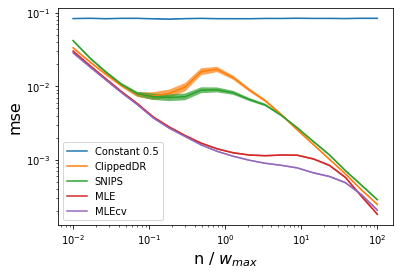

In [18]:
import pickle
del allres
allres = pickle.load(open( "epsilongreedy_estimatewithcv_twoactions_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in reversed(allres):
    x = [ x[0] for x in res ]
    y = [ x[1]['mse'] for x in res ]
    ylo = [ x[1]['mse'] - 1.96 * x[1]['msestd'] for x in res ]
    yhi = [ x[1]['mse'] + 1.96 * x[1]['msestd'] for x in res ]
    FlassPlot.plt().loglog([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.7)
FlassPlot.plt().legend()
FlassPlot.axeslabel('n / $w_{max}$', 'mse')

In [19]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)

def getenv():
    import environments.DoubleDouble
    return environments.DoubleDouble.DoubleDouble(numactions=5, seed=5, wsupport=[0, 2, 1000], expwsq=100)

myenv = getenv()
allres = []
for (name, method) in [ 
        ('MLEcv', lambda data, **kwargs: MLE.MLE.estimatewithcv(datagen=lambda: data, rangefn=myenv.range, **kwargs)[0]),
        ('MLE', lambda data, **kwargs: MLE.MLE.estimate(datagen=lambda:[(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)[0]),
        ('SNIPS', lambda data, **kwargs: SNIPS.estimate([(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)),
        ('ClippedDR', lambda data, **kwargs: ClippedDR.estimate([(c,w,r) for c, w, r, _ in data], wmin=myenv.range('wmin'), wmax=myenv.range('wmax'), **kwargs)),
        ('Constant 0.5', lambda **kwargs: 0.5),
    ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv(), method, ndataperpt=10000):
        res.append(zzz)
        print('{}'.format((zzz[0], { k: round(v, 4) for k, v in zzz[1].items() })), flush=True)
    allres.append((name, [(x[0] / myenv.range('wmax'), x[1]) for x in res]))
import pickle
pickle.dump( allres, open( "epsilongreedy_estimatewithcv_fiveactions_allres.p", "wb" ) )

****** MLEcv ******
(10, {'bias': 0.0037, 'biasstd': 0.0017, 'mse': 0.0275, 'msestd': 0.0004, 'ess': 4.5424, 'essstd': 0.0157})
(17, {'bias': 0.0002, 'biasstd': 0.0013, 'mse': 0.0178, 'msestd': 0.0003, 'ess': 7.6859, 'essstd': 0.0207})
(27, {'bias': 0.0, 'biasstd': 0.0011, 'mse': 0.0122, 'msestd': 0.0002, 'ess': 12.1503, 'essstd': 0.0265})
(43, {'bias': 0.0012, 'biasstd': 0.0009, 'mse': 0.0083, 'msestd': 0.0001, 'ess': 19.2975, 'essstd': 0.0348})
(70, {'bias': 0.0004, 'biasstd': 0.0008, 'mse': 0.0056, 'msestd': 0.0001, 'ess': 31.3885, 'essstd': 0.0474})
(113, {'bias': 0.001, 'biasstd': 0.0006, 'mse': 0.0037, 'msestd': 0.0001, 'ess': 50.4232, 'essstd': 0.0759})
(184, {'bias': 0.0005, 'biasstd': 0.0005, 'mse': 0.0027, 'msestd': 0.0, 'ess': 81.5802, 'essstd': 0.1288})
(298, {'bias': 0.0002, 'biasstd': 0.0005, 'mse': 0.0021, 'msestd': 0.0, 'ess': 130.929, 'essstd': 0.2242})
(484, {'bias': 0.0003, 'biasstd': 0.0004, 'mse': 0.0016, 'msestd': 0.0, 'ess': 207.7364, 'essstd': 0.4796})
(785, {'b

(14385, {'bias': 0.001, 'biasstd': 0.0004, 'mse': 0.0016, 'msestd': 0.0, 'ess': 1659.2067, 'essstd': 27.0898})
(23358, {'bias': 0.0003, 'biasstd': 0.0003, 'mse': 0.001, 'msestd': 0.0, 'ess': 1320.7758, 'essstd': 31.1156})
(37927, {'bias': 0.0008, 'biasstd': 0.0003, 'mse': 0.0006, 'msestd': 0.0, 'ess': 881.8426, 'essstd': 25.9782})
(61585, {'bias': 0.0, 'biasstd': 0.0002, 'mse': 0.0004, 'msestd': 0.0, 'ess': 786.4153, 'essstd': 13.2184})
(100000, {'bias': 0.0001, 'biasstd': 0.0002, 'mse': 0.0002, 'msestd': 0.0, 'ess': 1109.1638, 'essstd': 5.9651})
****** Constant 0.5 ******
(10, {'bias': 0.003, 'biasstd': 0.0029, 'mse': 0.0829, 'msestd': 0.0007, 'ess': 4.5424, 'essstd': 0.0157})
(17, {'bias': 0.0058, 'biasstd': 0.0029, 'mse': 0.0835, 'msestd': 0.0007, 'ess': 7.6859, 'essstd': 0.0207})
(27, {'bias': 0.001, 'biasstd': 0.0029, 'mse': 0.0826, 'msestd': 0.0007, 'ess': 12.1503, 'essstd': 0.0265})
(43, {'bias': 0.0014, 'biasstd': 0.0029, 'mse': 0.0834, 'msestd': 0.0007, 'ess': 19.2975, 'essstd

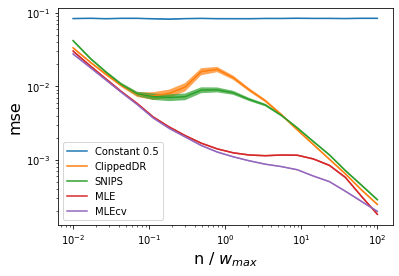

In [20]:
import pickle
del allres
allres = pickle.load(open( "epsilongreedy_estimatewithcv_fiveactions_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in reversed(allres):
    x = [ x[0] for x in res ]
    y = [ x[1]['mse'] for x in res ]
    ylo = [ x[1]['mse'] - 1.96 * x[1]['msestd'] for x in res ]
    yhi = [ x[1]['mse'] + 1.96 * x[1]['msestd'] for x in res ]
    FlassPlot.plt().loglog([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.7)
FlassPlot.plt().legend()
FlassPlot.axeslabel('n / $w_{max}$', 'mse')